# Running trVAE on Haber dataset

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import trvae

Using TensorFlow backend.


In [2]:
sc.set_figure_params(dpi=200)

## Loading & preparing data

In [3]:
condition_key = "condition"
cell_type_key = "cell_label"

In [4]:
adata = sc.read("./data/haber_count/haber_count.h5ad")
adata

AnnData object with n_obs × n_vars = 9842 × 15215 
    obs: 'batch', 'barcode', 'condition', 'cell_label'

## Normalizing & Extracting Top 1000 Highly Variable Genes 
We can preserve more genes (up to 7000 like scGen) but in order to train the network quickly, we will extract top 1000 genes

In [5]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [7]:
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 9842 × 1000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Data Visualization

In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


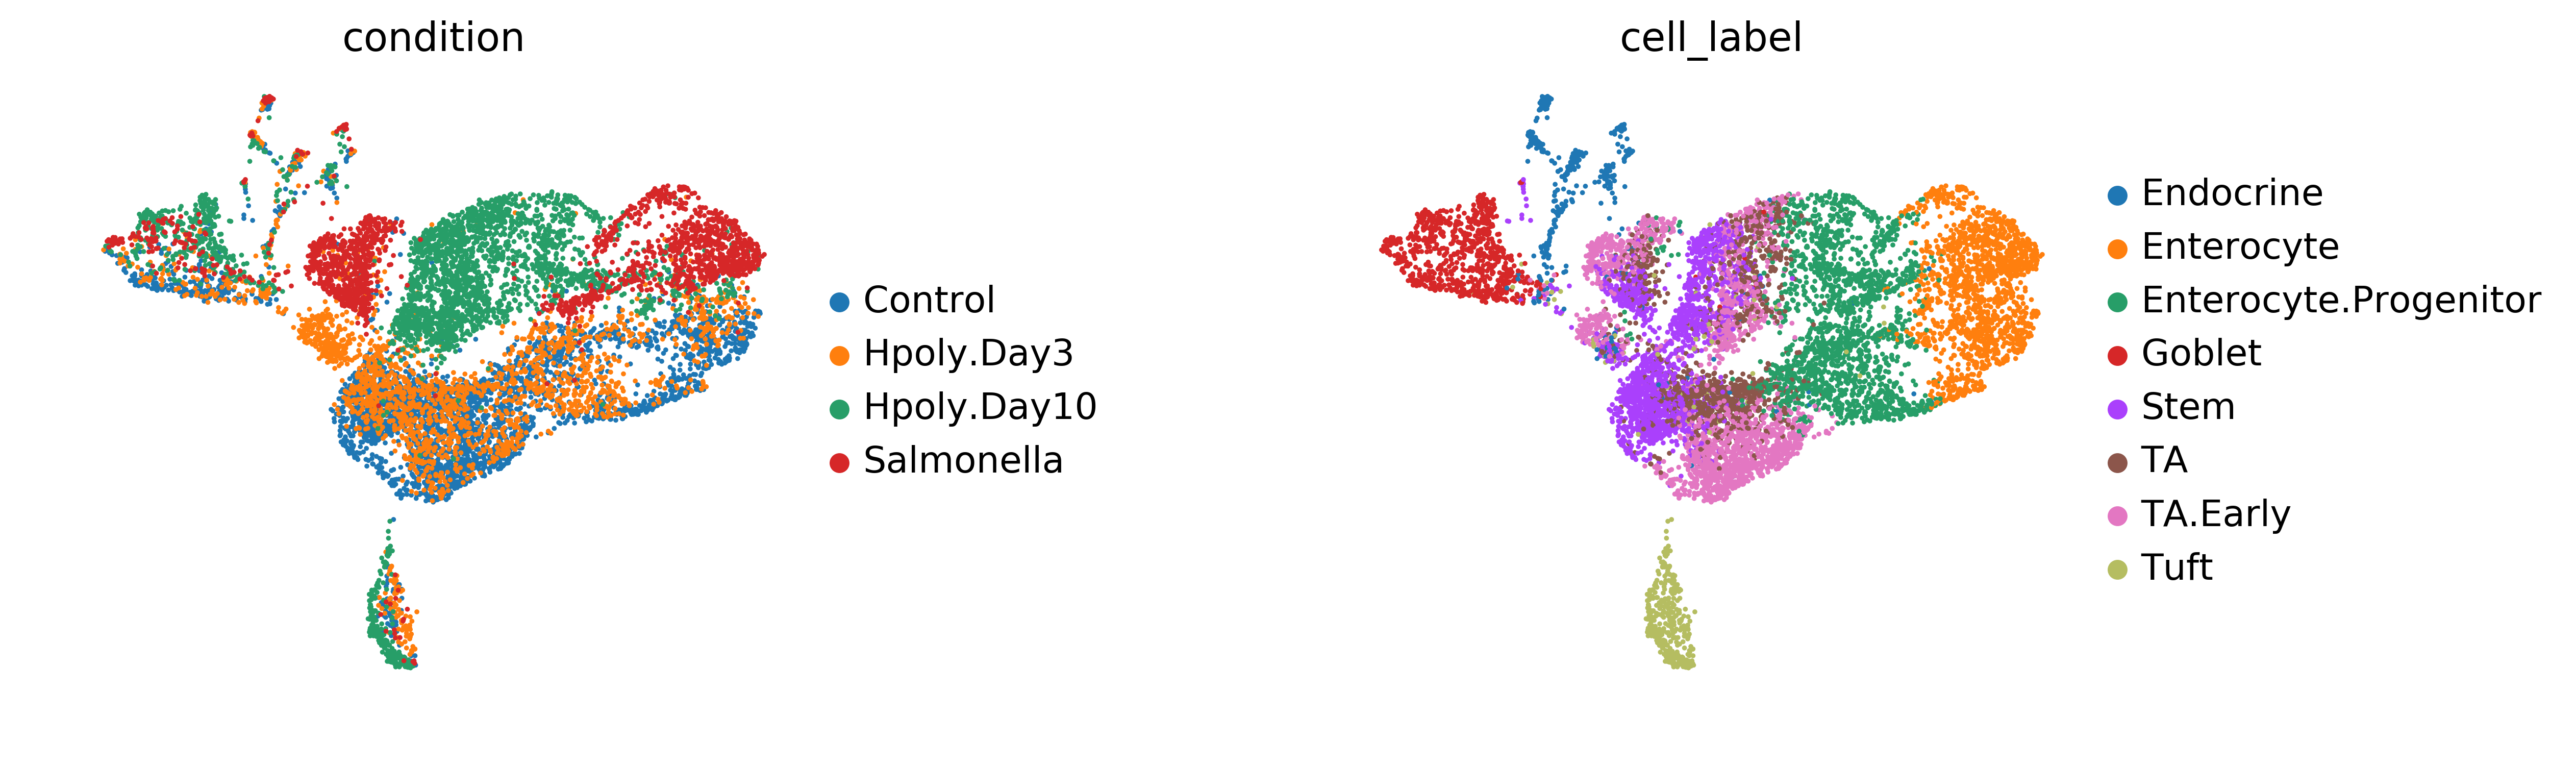

In [11]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

## Train/Test Split

In [8]:
train_adata, valid_adata = trvae.utils.train_test_split(adata, train_frac=0.80)

In [9]:
train_adata.shape, valid_adata.shape

((7873, 1000), (1969, 1000))

## Calculate number of batches

In [10]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

In [11]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = trvae.utils.create_dictionary(conditions, [])
condition_encoder

{'Control': 0, 'Hpoly.Day3': 1, 'Hpoly.Day10': 2, 'Salmonella': 3}

## Create the network
Some of network parameters:
 - __x_dimension__: number of features (necessary)
 - __n_conditons__: total number of batches (necessary)
 - __architecture__: architecture of the network (optional)
 - __output_activation__: activation function of trVAE's last layer 
     can be one of the `relu`, `leaky_relu`, `linear`, ... 

In [12]:
network = trvae.archs.trVAE(x_dimension=train_adata.shape[1],
                            architecture=[128, 32],
                            z_dimension=10,
                            n_conditions=n_conditions,
                            output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1004)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## Training trVAE
Parameters:
   - __train_adata__: `anndata` object for training trVAE
   - __valid_adata__: `anndata` object for validating trVAE (default = None)
   - __condition_key__: (`str`) name of the column containing batches' names in `train_adata` and `valid_adata` (Necessary)
   - __condition_encoder__: (`dict`) dictionary of encoded batches (keys: batch names, values: encoded integers) (default = None)
   - __verbose__: (`int`) level of verbosity (default = 0)

__NOTE: This will take like an hour in a single GPU__

In [ ]:
network.train(train_adata,
              valid_adata,
              condition_key=condition_key,
              condition_encoder=condition_encoder,
              verbose=0,
)

## Getting batch-corrected adata

In [15]:
labels, _ = trvae.tl.label_encoder(adata, condition_key=condition_key, label_encoder=condition_encoder)

In [16]:
network.get_corrected(adata, labels, return_z=True)

Now two matrices have been added to adata
 - __mmd_latent__: (`numpy ndarray`) output of MMD Layer in trVAE 
 - __reconstructed__: (`numpy ndarray`) reconstructed data with dimension of original feature space
 - __z_latent__: (`numpy ndarray`) output of bottleneck layer of trVAE (optional)
 
For evaluating how good trVAE has corrected the batches, we recommend using __mmd_latent__ matrix.

In [17]:
adata

AnnData object with n_obs × n_vars = 9842 × 1000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'mmd_latent', 'reconstructed', 'z_latent'

## MMD Layer UMAP visualization

In [18]:
mmd_latent = adata.obsm['mmd_latent']
mmd_adata = sc.AnnData(mmd_latent, obs=adata.obs)
mmd_adata

AnnData object with n_obs × n_vars = 9842 × 128 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'

In [19]:
sc.pp.neighbors(mmd_adata)
sc.tl.umap(mmd_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


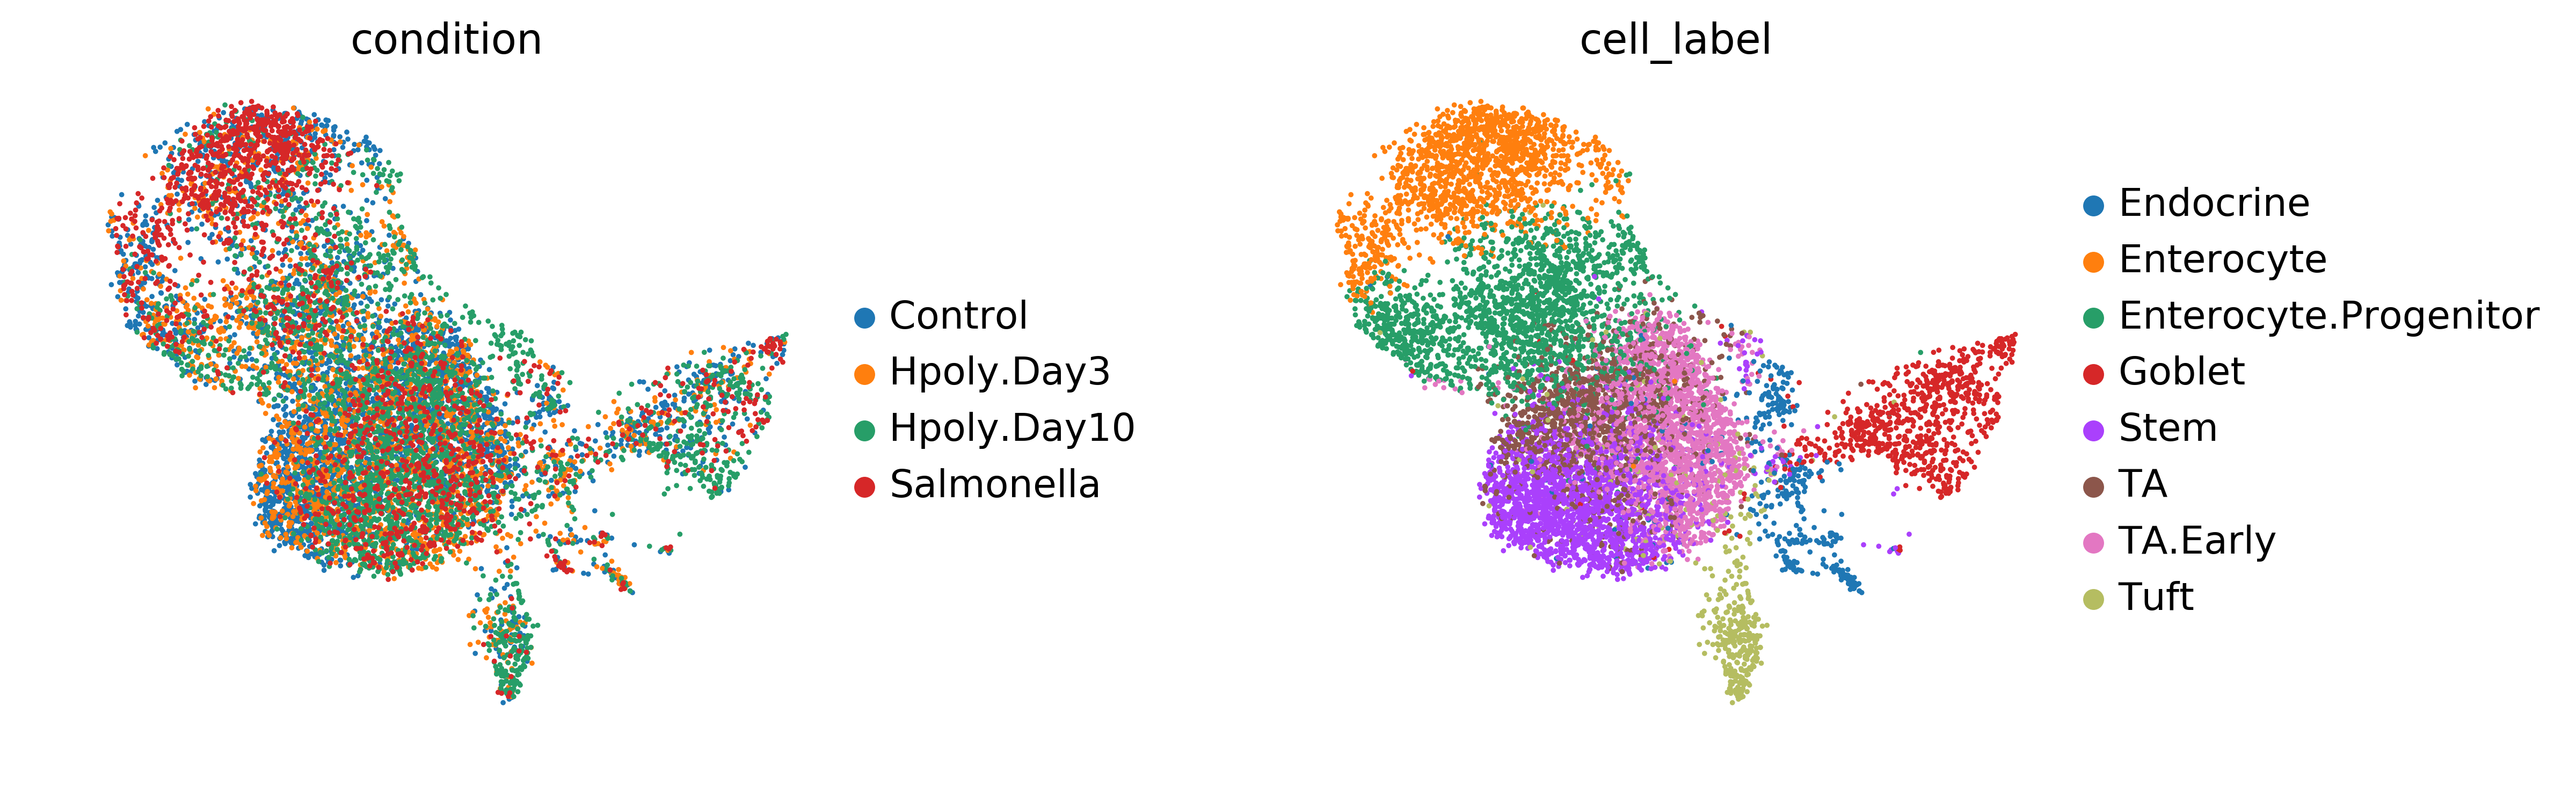

In [34]:
sc.pl.umap(mmd_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)